In [19]:
import duckdb as db 
con = db.connect()
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_parquet("iowa_liquor_2023_2025.parquet") # pandas df for plotting
con.execute("CREATE TABLE sales AS SELECT * FROM df") # duckdb table for easy querying

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [15]:
len(df)

6858350

In [16]:
df.describe()

,date,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,sale_bottles,sale_dollars,sale_liters,sale_gallons
count,6858350,6.858350e+06,6.858350e+06,6.858350e+06,6.858350e+06,6.858350e+06,6.858350e+06,6.858350e+06,6.858350e+06
mean,2024-04-26 17:05:53.179877,1.171954e+01,7.865333e+02,1.349316e+01,2.024026e+01,1.202753e+01,1.700976e+02,8.971793e+00,2.364388e+00
min,2023-01-02 00:00:00,1.000000e+00,2.000000e+01,5.200000e-01,0.000000e+00,-7.680000e+02,-8.355840e+03,-1.344000e+03,-3.550400e+02
25%,2023-08-29 00:00:00,6.000000e+00,3.750000e+02,6.500000e+00,9.750000e+00,3.000000e+00,5.001000e+01,1.500000e+00,3.900000e-01
50%,2024-04-25 00:00:00,1.200000e+01,7.500000e+02,9.990000e+00,1.499000e+01,6.000000e+00,9.216000e+01,4.500000e+00,1.180000e+00
75%,2024-12-20 00:00:00,1.200000e+01,1.000000e+03,1.600000e+01,2.400000e+01,1.200000e+01,1.710000e+02,9.600000e+00,2.530000e+00
max,2025-08-29 00:00:00,6.000000e+01,5.250000e+03,2.498902e+04,3.748353e+04,1.320000e+04,2.608320e+05,1.320000e+04,3.487070e+03
std,NaN,8.295312e+00,5.319632e+02,2.006096e+01,3.009045e+01,3.508362e+01,6.164359e+02,4.077390e+01,1.077152e+01


In [18]:
df.columns

Index(['invoice_line_no', 'date', 'store', 'name', 'address', 'city',
       'zipcode', 'store_location', 'county', 'category', 'category_name',
       'vendor_no', 'vendor_name', 'itemno', 'im_desc', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'sale_bottles', 'sale_dollars', 'sale_liters', 'sale_gallons'],
      dtype='object')

# Booze 'R' Us

Goal: predicting scales and growth strategy

### Sales Over Time

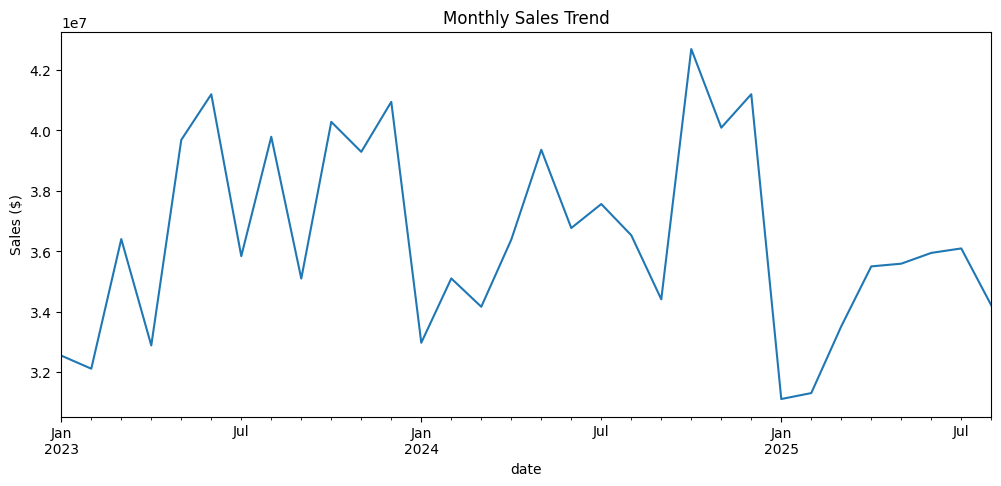

In [21]:
monthly_sales = df.groupby(df['date'].dt.to_period('M'))['sale_dollars'].sum()
monthly_sales.plot(kind='line', figsize=(12,5))
plt.title("Monthly Sales Trend")
plt.ylabel("Sales ($)")
plt.show()

### Top stores

Can use their information to identify early patterns (location, type of sales, etc)

store  name                                           
2633   HY-VEE #3 / BDI / DES MOINES                       38958191.40
4829   CENTRAL CITY 2                                     36091290.15
5916   ANOTHER ROUND / DEWITT                             17615198.55
2512   HY-VEE WINE AND SPIRITS #1 (1281) / IOWA CITY      15512813.04
3773   BENZ DISTRIBUTING                                  13762283.42
6242   WALL TO WALL WINE AND SPIRITS / WEST DES MOINES    11402169.85
4312   I-80 LIQUOR / COUNCIL BLUFFS                       10298670.13
3814   COSTCO WHOLESALE #788 / WDM                         9554157.29
5102   WILKIE LIQUORS                                      8981478.33
3420   SAM'S CLUB 6344 / WINDSOR HEIGHTS                   7918749.31
Name: sale_dollars, dtype: float64


<Axes: title={'center': 'Top 10 Stores by Sales'}, ylabel='store,name'>

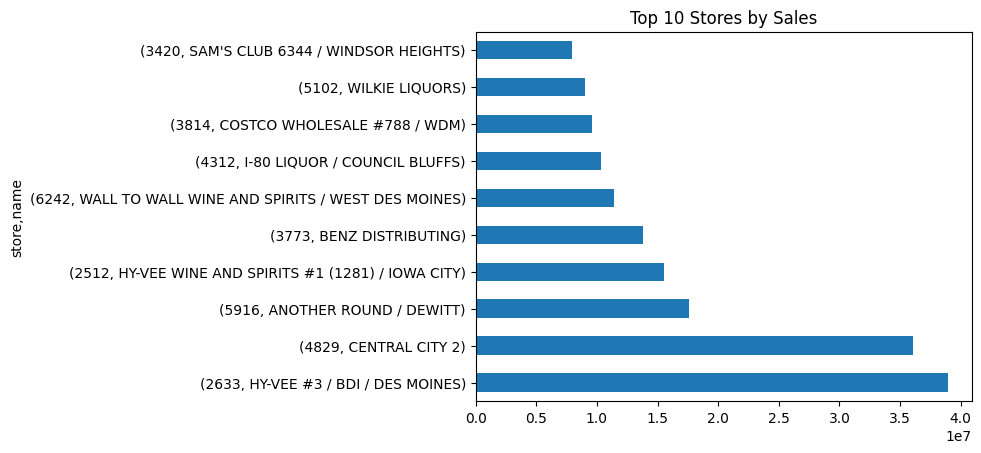

In [22]:
top_stores = df.groupby(['store','name'])['sale_dollars'].sum().nlargest(10)
print(top_stores)
top_stores.plot(kind='barh', title="Top 10 Stores by Sales")


### Best-selling categories

<Axes: title={'center': 'Top Categories by Sales'}, xlabel='category_name'>

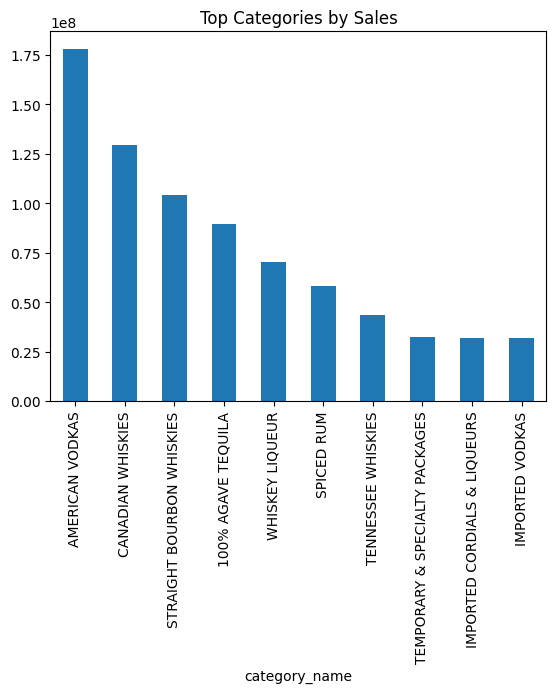

In [23]:
cat_sales = df.groupby('category_name')['sale_dollars'].sum().nlargest(10)
cat_sales.plot(kind='bar', title="Top Categories by Sales")

### Top vendors

Top 5 vendors share: 0.5539267661629212


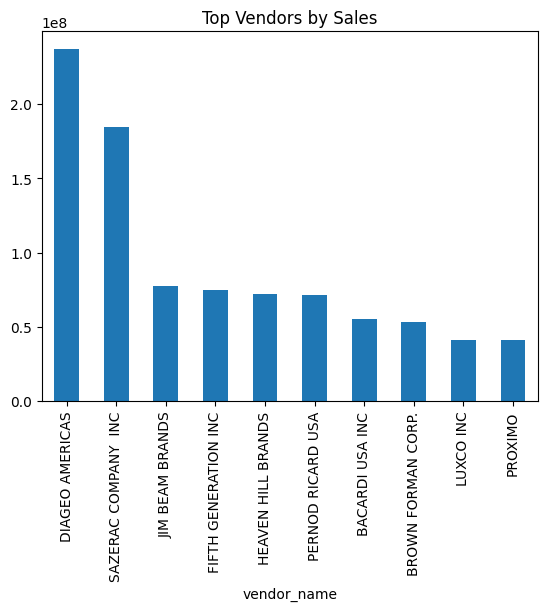

In [24]:
vendor_sales = df.groupby('vendor_name')['sale_dollars'].sum().sort_values(ascending=False)
vendor_sales.head(10).plot(kind='bar', title="Top Vendors by Sales")
print("Top 5 vendors share:", vendor_sales.head(5).sum() / vendor_sales.sum())

### Regional Opportunities

County sales vs. number of stores

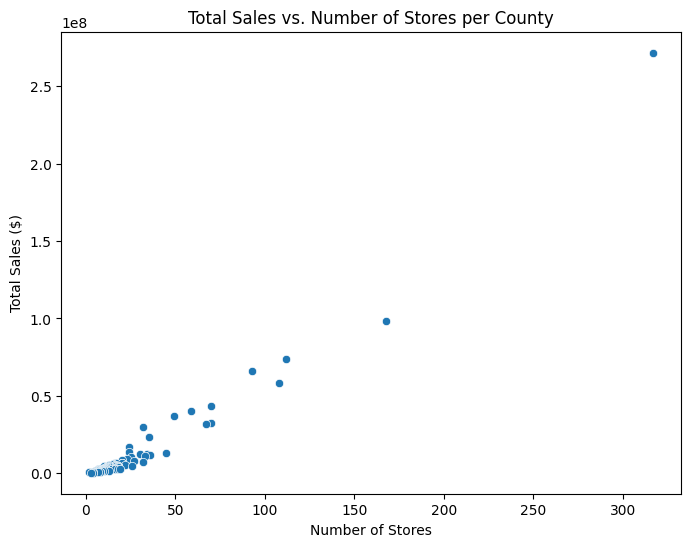

In [29]:
county_sales = df.groupby('county')['sale_dollars'].sum().reset_index(name="total_sales")
county_stores = df.groupby('county')['store'].nunique().reset_index(name="num_stores")
county_summary = county_sales.merge(county_stores, on="county", how="left")
county_summary['avg_sales_per_store'] = county_summary['total_sales'] / county_summary['num_stores']
county_summary = county_summary.sort_values('total_sales', ascending=False)

plt.figure(figsize=(8,6))
sns.scatterplot(data=county_summary, x="num_stores", y="total_sales")
plt.title("Total Sales vs. Number of Stores per County")
plt.xlabel("Number of Stores")
plt.ylabel("Total Sales ($)")
plt.show()

Average sales/store in each county:

Text(0, 0.5, 'County')

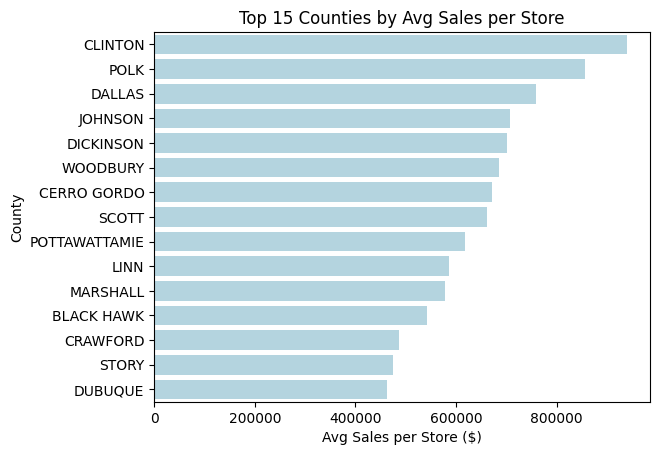

In [33]:
top_avg = county_summary.sort_values('avg_sales_per_store', ascending=False).head(15)
sns.barplot(data=top_avg, x="avg_sales_per_store", y="county", color="lightblue")
plt.title("Top 15 Counties by Avg Sales per Store")
plt.xlabel("Avg Sales per Store ($)")
plt.ylabel("County")


- Consider combining census data with this county performance stuff, but I don't have that right now.

# DEAD Nonprofit

Goal: identifying patterns to improve safety

### Temporal patterns

When are sales peaking? How can this help us identify increased risk?

*I will use only 2024 data for this because it is the most data we have for one full year.*

/var/folders/4l/944cj3pd4hn2cm3hpy927z600000gn/T/ipykernel_29611/1198060428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df24['weekday'] = df24['date'].dt.day_name()


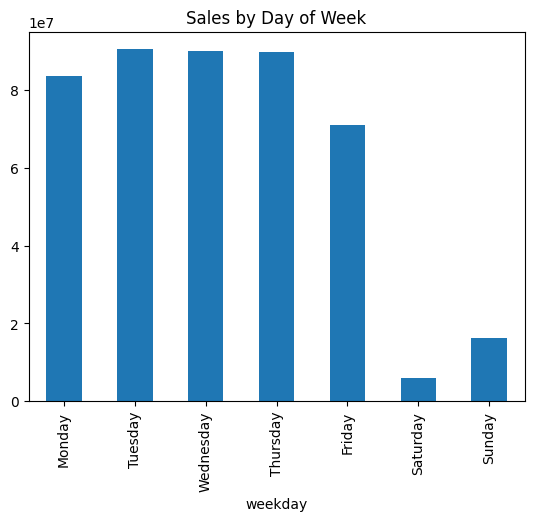

In [57]:
df24 = df[df['date'].dt.year == 2024]
df24['weekday'] = df24['date'].dt.day_name()
weekday_sales = df24.groupby('weekday')['sale_dollars'].sum().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
weekday_sales.plot(kind='bar', title="Sales by Day of Week")
plt.show()

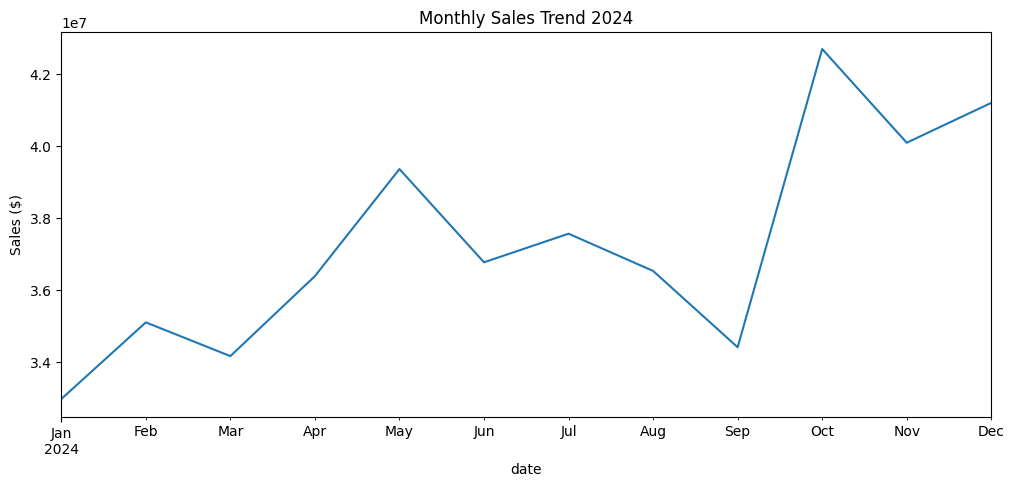

In [58]:
monthly_sales = df24.groupby(df24['date'].dt.to_period('M'))['sale_dollars'].sum()
monthly_sales.plot(kind='line', figsize=(12,5))
plt.title("Monthly Sales Trend 2024")
plt.ylabel("Sales ($)")
plt.show()

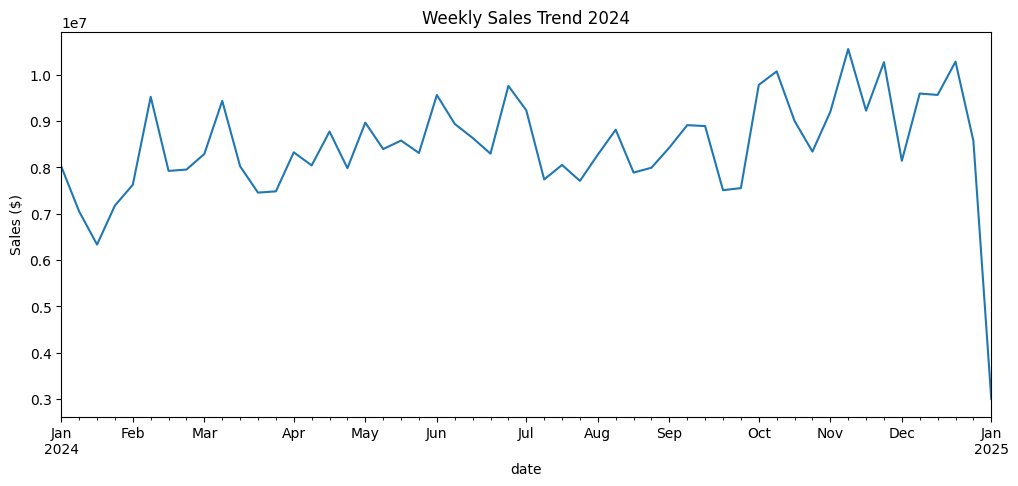

In [59]:
monthly_sales = df24.groupby(df24['date'].dt.to_period('W'))['sale_dollars'].sum()
monthly_sales.plot(kind='line', figsize=(12,5))
plt.title("Weekly Sales Trend 2024")
plt.ylabel("Sales ($)")
plt.show()

### Hotspots

Potentially outlier stores that may be high-risk. Can look for reasons.

In [61]:
store_totals = df.groupby(['store','city'])['sale_dollars'].sum().reset_index()
store_totals.sort_values('sale_dollars', ascending=False).head(15)

,store,city,sale_dollars
616,2633,DES MOINES,38958191.40
1311,4829,DES MOINES,36091290.15
2027,5916,DEWITT,17615198.55
533,2512,IOWA CITY,15512813.04
796,3773,CEDAR RAPIDS,13762283.42
2281,6242,WEST DES MOINES,11402169.85
995,4312,COUNCIL BLUFFS,10298670.13
806,3814,WEST DES MOINES,9554157.29
1445,5102,MOUNT VERNON,8981478.33
720,3420,WINDSOR HEIGHTS,7918749.31


In [78]:
a=[1,2,3]
a[-3]

1

In [80]:
1%-5

-4

In [89]:
-7%4

1